### Import Libraries

In [57]:
import numpy as np
import os
import random

import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten

In [58]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Dataset Path

In [59]:
dataset_path = "../../dataset/xray_new/COVID_19_Radiography_Dataset_Refined/"

### Define batch size and other constants

In [28]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 20
BASE_MODELS = ["vgg16net", "resnet101", "densenet169"]
# seed_no = random.randint(1,100)

### Define train data generator

In [29]:
train_datagen = ImageDataGenerator(
  rescale=1./255,
  # rotation_range=10,
  width_shift_range=0.1,
  height_shift_range=0.1,
  # shear_range=0.1,
  zoom_range=0.2,
  # horizontal_flip=True,
  fill_mode='nearest',
  validation_split=0.2
)

### Define test data generator

In [30]:
test_datagen = ImageDataGenerator(rescale=1./255,
                                  # fill_mode='nearest'
                                 )

### Define train generator

In [31]:
train_generator = train_datagen.flow_from_directory(
  dataset_path + "training",
  # color_mode="grayscale",
  subset="training",
  # seed=seed_no,
  class_mode='categorical',
  target_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

Found 3597 images belonging to 3 classes.


In [8]:
NUM_CLASSES = len(train_generator.class_indices)
class_names = ['Normal', 'Pneumonia', 'COVID-19']

### Define test generator

In [32]:
test_generator = train_datagen.flow_from_directory(
  dataset_path + "training",
  # color_mode="grayscale",
  subset="validation",
  # seed=seed_no,
  class_mode='categorical',
  target_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

Found 899 images belonging to 3 classes.


### Model selector

In [23]:
def get_model(img_size, model_sel):
  if model_sel == 1:
    vgg_pre_t = VGG16(input_shape=(img_size, img_size, 3), include_top=False, weights ='imagenet')
    return vgg_pre_t, 25088

  elif model_sel == 2:
    resnet_pre_t = ResNet101(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
    return resnet_pre_t, 100352

  elif model_sel == 3:
    densenet169_pre_t = DenseNet169(input_shape=(img_size, img_size, 3), include_top=False, weights ='imagenet' )
    return densenet169_pre_t, 81536

### Select Base model

In [33]:
select_model = 1 # int(input("Enter the number for: \n 1) VGGNET16 \n 2) Resnet101  \n 3) Densenet169 "))

### Load pre-trained selected model without classification layers

In [34]:
base_model, feature_size = get_model(IMAGE_SIZE[0], select_model)

### Freeze the layers of the base model

In [35]:
print(len(base_model.layers))
for layer in base_model.layers:
  layer.trainable = False

19


### Add custom classification layers on top of selected base model

In [36]:
x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = MaxPooling2D()(x)
# x = Dense(1024, activation='relu')(x)
x = Flatten()(x)

predictions = Dense(NUM_CLASSES, activation='softmax')(x)
print(x.shape, predictions.shape)

(None, 25088) (None, 3)


In [119]:
# output = base_model.output
# output = AveragePooling2D(pool_size=(4, 4))(output)
# output = Dense(256, activation="relu")(output)
# output = Dropout(0.5)(output)
# output = Dense(4, activation="softmax")(output)

In [120]:
# print(len(base_model.layers))
# for layer in base_model.layers:
#   layer.trainable = False

In [121]:
# model = Model(inputs=base_model.input, outputs=output)

### Combine base model and custom layers into a new model

In [37]:
model = Model(inputs=base_model.input, outputs=predictions)

### Compile the model

In [123]:
# INIT_LR = 0.001
# EPOCHS = 40
# BATCHSIZE = 32
# optimizer = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

In [124]:
# model.compile(optimizer='optimizer', loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the model

In [41]:
history = model.fit(train_generator,
          steps_per_epoch=len(train_generator),
          epochs=EPOCHS,
          validation_data=test_generator,
          validation_steps=len(test_generator))

Epoch 1/20
57/57 [==============================] - 46s 792ms/step - loss: 0.5726 - accuracy: 0.7640 - val_loss: 0.2382 - val_accuracy: 0.9244
Epoch 2/20
57/57 [==============================] - 45s 785ms/step - loss: 0.3184 - accuracy: 0.8707 - val_loss: 0.2450 - val_accuracy: 0.9099
Epoch 3/20
57/57 [==============================] - 44s 777ms/step - loss: 0.2671 - accuracy: 0.8982 - val_loss: 0.2263 - val_accuracy: 0.9166
Epoch 4/20
57/57 [==============================] - 44s 774ms/step - loss: 0.2360 - accuracy: 0.9133 - val_loss: 0.1821 - val_accuracy: 0.9355
Epoch 5/20
57/57 [==============================] - 44s 776ms/step - loss: 0.2196 - accuracy: 0.9152 - val_loss: 0.1677 - val_accuracy: 0.9399
Epoch 6/20
57/57 [==============================] - 44s 776ms/step - loss: 0.2152 - accuracy: 0.9183 - val_loss: 0.2732 - val_accuracy: 0.8977
Epoch 7/20
57/57 [==============================] - 44s 781ms/step - loss: 0.2033 - accuracy: 0.9194 - val_loss: 0.1269 - val_accuracy: 0.9555

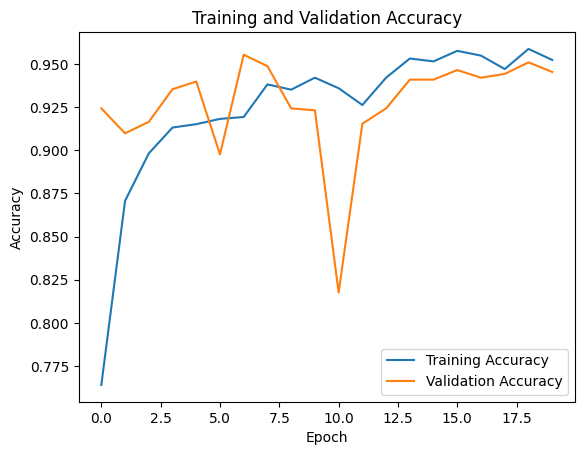

In [42]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

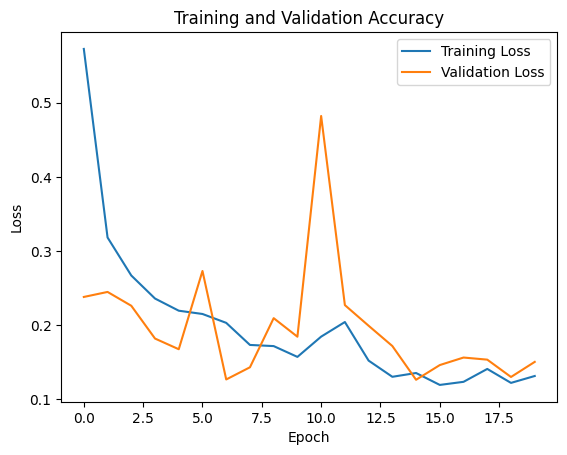

In [43]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Save model for future use

In [48]:
model_name = "../models/xray" + "_" + BASE_MODELS[select_model-1] + "_" + str(BATCH_SIZE) + "_" + str(EPOCHS) + "_expert_acc_" + str(round(test_accuracy * 100, 0)) + ".h5"
model.save(model_name)

### Evaluate the model

In [50]:
# Load the saved model
# model_name = "../models/xray_vgg16net_32_20_expert_acc_94.0.h5"
# model = load_model(model_name)

In [51]:
test_data, test_labels = [], []
for _ in range(len(test_generator)):
    batch_data, batch_labels = test_generator.next()
    test_data.append(batch_data)
    test_labels.append(batch_labels)

test_data = np.concatenate(test_data)
test_labels = np.concatenate(test_labels)

# Make predictions on the test set
predictions = model.predict(test_data)

29/29 [==============================] - 3s 34ms/step


In [55]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, precision_score, f1_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

15/15 [==============================] - 9s 574ms/step - loss: 0.1293 - accuracy: 0.9477


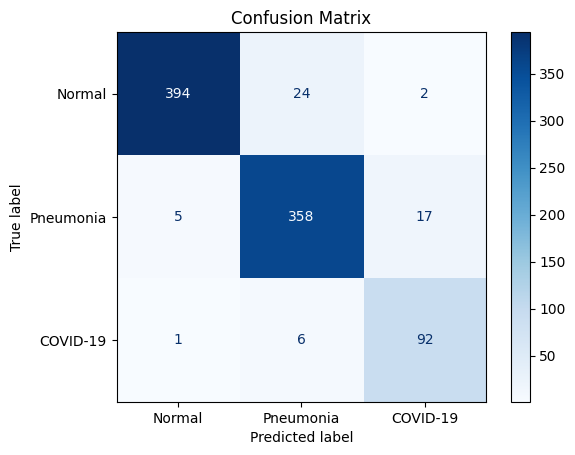

Accuracy: 0.9477196931838989
Loss: 0.1293274164199829
Precision: 0.9418994413407821
F1 Score: 0.939799331103679
AUC-ROC Score: 0.9922797670381501
Confusion Matrix:
[[394  24   2]
 [  5 358  17]
 [  1   6  92]]


In [54]:
# Convert predicted probabilities to predicted class labels
predicted_labels = (predictions > 0.5).astype(int)  # Thresholding at 0.5

# predicted_labels2 = (inference_predictions > 0.5).astype(int)  # Thresholding at 0.5

# p_l = [np.where(x == 1)[0][0] for x in predicted_labels]
p_l = [];
for x in predicted_labels:
    try:
        p_l.append(np.where(x == 1)[0][0])
    except:
        p_l.append(0)
t_l = [np.where(x == 1)[0][0] for x in test_labels]
# t_l = [np.where(x == 1)[0][0] for x in inference_labels]

test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))

# Calculate precision
precision = precision_score(test_labels, predicted_labels, average='micro')

# Calculate F1 score
f1 = f1_score(test_labels, predicted_labels, average='micro')

# Calculate AUC-ROC
auc_roc = roc_auc_score(test_labels, predictions, average='micro')

# Calculate confusion matrix
# conf_matrix = multilabel_confusion_matrix(test_labels, predicted_labels)
conf_matrix = confusion_matrix(t_l, p_l)


disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy:", test_accuracy)
print("Loss:", test_loss)
print("Precision:", precision)
print("F1 Score:", f1)
print("AUC-ROC Score:", auc_roc)
print("Confusion Matrix:")
print(conf_matrix)

### Print model summary

In [56]:
# model.summary()